In [91]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import findspark
try:
    findspark.init()
except:
    PYSPARK_PATH = '../spark/spark-2.4.3-bin-hadoop2.7/' # change path to yours
    findspark.init(PYSPARK_PATH)
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.functions import UserDefinedFunction

In [15]:
import os
from glob import glob
import numpy as np
import pandas as pd

import sys
stages = ["1_data_collection", "2_feature_engineering", "3_modeling"]
for stage in stages:
    sys.path.insert(0, stage)

from xml_to_csv import process_dumps
from csv_to_features import create_features
from features_to_clusters import get_clusters

# Train

## Configure for sample data

In [4]:
DATA_DIR = "sample_data"
DATE = "20190701"
XML_DIR = os.path.join(DATA_DIR, "xml")
CSV_DIR = os.path.join(DATA_DIR, "csv")

DUMP_BASE_URL = "https://dumps.wikimedia.org/enwiki/{}".format(DATE)

dump_names = ["enwiki-20190701-pages-articles-multistream14.xml-p7697599p7744799"]
dump_ext = ".bz2"

## Collect data

In [52]:
!rm $DATA_DIR/xml/* 2> null
for dump_name in dump_names:
    print("Loading {}...".format(dump_name))
    !wget -P $DATA_DIR/xml/ $DUMP_BASE_URL/$dump_name$dump_ext 2> /dev/null
    !bzip2 -d $DATA_DIR/xml/$dump_name$dump_ext 2> /dev/null

Loading:
	> enwiki-20190701-pages-articles-multistream14.xml-p7697599p7744799...


In [53]:
print('Parsing XML + Fetching ORES...')
process_dumps(XML_DIR, CSV_DIR, jupyter=True)
!rm $DATA_DIR/xml/* 2> null
print('Collected wiki dump(s) with ORES in {}/csv'.format(DATA_DIR))

Parsing XML + Fetching ORES...
XML Files found: enwiki-20190701-pages-articles-multistream14.xml-p7697599p7744799
Processing enwiki-20190701-pages-articles-multistream14.xml-p7697599p7744799


Alert: Exception fetching ORES score for revisions. Ex: 'score'
Alert: Exception fetching ORES score for revisions. Ex: 'score'
Wiki dump(s) with ORES collected in sample_data/csv


## Extract features

In [199]:
df_features, pdf_features = create_features(CSV_DIR, DATE)

## Cluster

In [193]:
import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['image.cmap'] = 'inferno'
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib._color_data as mcd

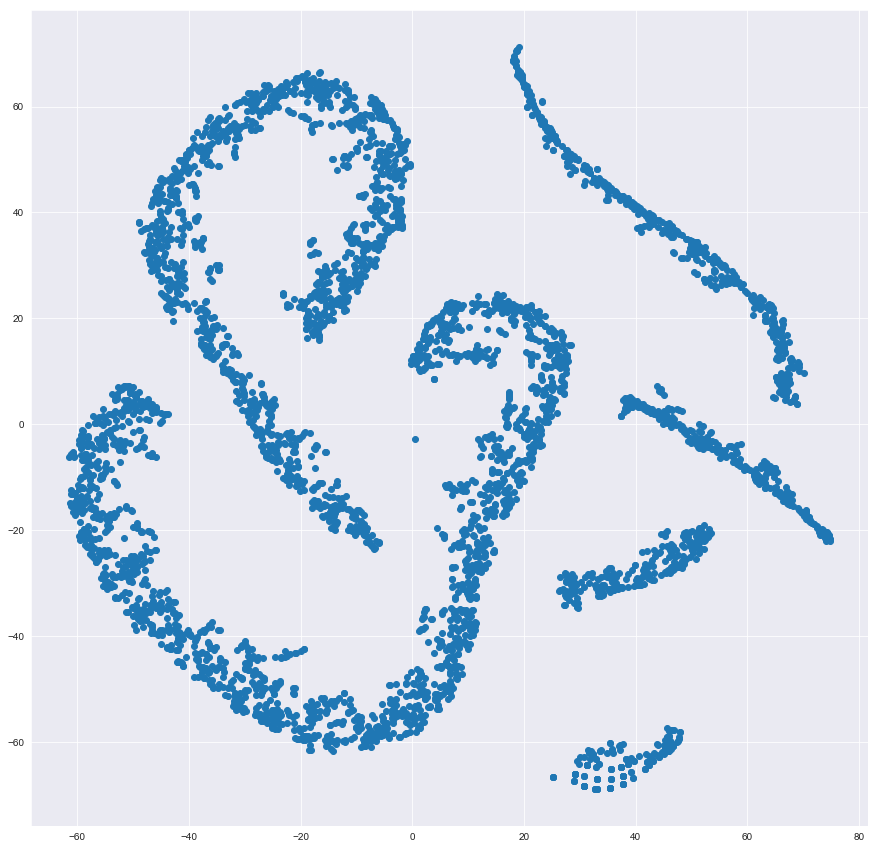

In [198]:
features_names = df_features.drop('_c0', 'title', 'Stub', 'Start', 'C', 'B', 'GA', 'FA').columns

df_data_for_tsne = pdf_features[features_names]
embedded_tsne = TSNE(n_components=2).fit_transform(df_data_for_tsne.values)

plt.figure(figsize=(15, 15))
plt.scatter(*embedded_tsne.T)
plt.show()

# Test